## Overview
In this project, a convolutional neural network (CNN) was developed to classify images into two categories: Cats and Dogs. Using TensorFlow and Keras, the project involved preprocessing the Cats vs. Dogs dataset, constructing a CNN model, and processing the data through training and validation stages. Key evaluations included model's accuracy rate and loss value, a detailed analysis using a confusion matrix, an ROC curve, and misclassified images were examined for error analysis.

## Import Libraries

In [36]:
# Standard library imports
import os
import shutil
import random

# Data handling
import numpy as np
import pandas as pd

# Machine Learning and Neural Network libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 

# SciPy and Sklearn for additional functionalities
import scipy as sp
from scipy import ndimage
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [10]:

# File Paths for Dataset
cat_file_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat"
dog_file_path = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"

## Dataset Class Visualization


In [11]:
# Dataset Class Visualization
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir(cat_file_path))
n_cats = len(os.listdir(dog_file_path))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

## Splitting Dataset into train, validation, and test sets

In [12]:
# Data Splitting Function
def split_data(main_dir, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files, len(files)) # shuffles the data
    split = int(split_size * len(shuffled_files)) # the training split casted into int for numeric rounding
    train_files = shuffled_files[:split] # training split
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    validation_files = shuffled_files[split:split_valid_test] # validation split
    test_files = shuffled_files[split_valid_test:]

    return train_files, validation_files, test_files

# Split the data for cats and dogs
train_cats, val_cats, test_cats = split_data(cat_file_path)
train_dogs, val_dogs, test_dogs = split_data(dog_file_path)

print("Cats - Training:", len(train_cats), "Validation:", len(val_cats), "Test:", len(test_cats))
print("Dogs - Training:", len(train_dogs), "Validation:", len(val_dogs), "Test:", len(test_dogs))


Cats - Training: 11250 Validation: 625 Test: 625
Dogs - Training: 11250 Validation: 625 Test: 625


In [13]:
# Function to create a dataframe from file names and labels
def create_dataframe(file_names, label, main_dir):
    return pd.DataFrame({
        'filename': [os.path.join(main_dir, fname) for fname in file_names],
        'class': label
    })

# Create dataframes
train_df = pd.concat([create_dataframe(train_cats, 'cat', cat_file_path), create_dataframe(train_dogs, 'dog', dog_file_path)])
val_df = pd.concat([create_dataframe(val_cats, 'cat', cat_file_path), create_dataframe(val_dogs, 'dog', dog_file_path)])
test_df = pd.concat([create_dataframe(test_cats, 'cat', cat_file_path), create_dataframe(test_dogs, 'dog', dog_file_path)])

# Shuffle the dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

## Image Data Generators


In [14]:
# Image Data Generators

# Includes rescaling to normalize the image data. This transformation
# converts pixel values from the range [0, 255] to [0, 1], aiding in model training.
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen =  ImageDataGenerator(rescale=1./255.)
test_gen =  ImageDataGenerator(rescale=1./255.)

In [15]:
# Data Generators from Dataframes
train_generator = train_gen.flow_from_dataframe(dataframe=train_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
validation_generator = validation_gen.flow_from_dataframe(dataframe=val_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
test_generator = test_gen.flow_from_dataframe(dataframe=test_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')

Found 22498 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning:

Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.



Found 1250 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.


In [16]:
# Function to Plot Data
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    plt.show()


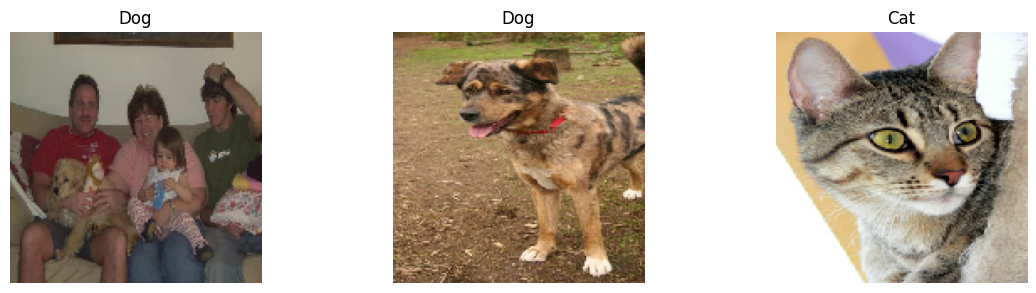

In [17]:
# Plotting Train Data Samples
plot_data(train_generator, 4)

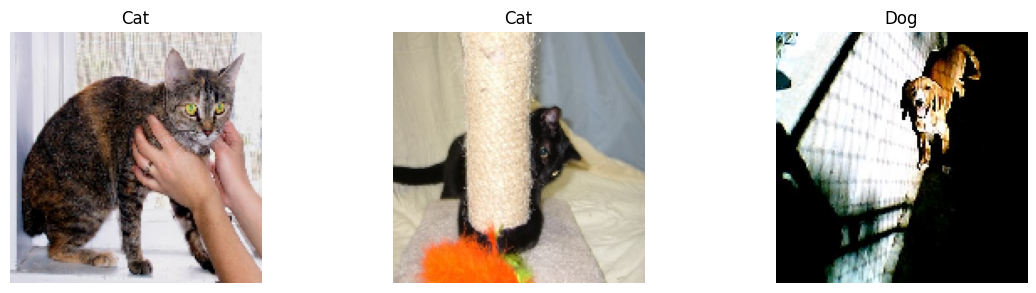

In [18]:
# Plotting Validation Data Samples
plot_data(validation_generator, 4)

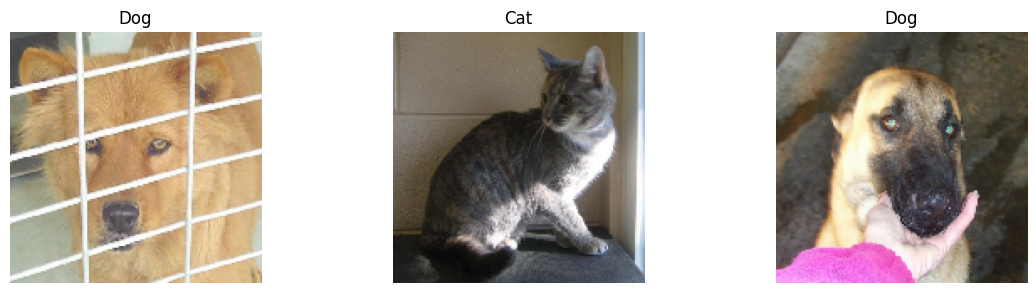

In [19]:
# Plotting Test Data Samples
plot_data(test_generator, 4)

## Model Architecture

In [24]:
# Building the CNN model
inputs = tf.keras.layers.Input(shape=(150,150,3))
# Convolutional layer with 32 filters of size 3x3, using ReLU activation function
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# Another Convolutional layer with increased filters for capturing more complex features
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# MaxPooling to reduce dimensionality and prevent overfitting
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# Additional Convolutional layers with increasing filter size for deeper feature extraction
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)

# Global Average Pooling layer for reducing overfitting and improving model efficiency
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

## Model Training

In [26]:
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training
r = model.fit(
        train_generator,
        epochs = 20, # Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/20
352/352 [==============================] - 54s 151ms/step - loss: 0.6959 - accuracy: 0.5419 - val_loss: 0.6852 - val_accuracy: 0.5368
Epoch 2/20
352/352 [==============================] - 52s 148ms/step - loss: 0.6398 - accuracy: 0.6451 - val_loss: 0.6482 - val_accuracy: 0.6360
Epoch 3/20
352/352 [==============================] - 53s 150ms/step - loss: 0.6045 - accuracy: 0.6808 - val_loss: 0.5997 - val_accuracy: 0.6744
Epoch 4/20
352/352 [==============================] - 52s 148ms/step - loss: 0.5690 - accuracy: 0.7112 - val_loss: 0.6023 - val_accuracy: 0.6776
Epoch 5/20
352/352 [==============================] - 53s 152ms/step - loss: 0.5393 - accuracy: 0.7331 - val_loss: 0.5337 - val_accuracy: 0.7496
Epoch 6/20
352/352 [==============================] - 53s 150ms/step - loss: 0.5006 - accuracy: 0.7630 - val_loss: 0.4838 - val_accuracy: 0.7864
Epoch 7/20
352/352 [==============================] - 53s 150ms/step - loss: 0.4616 - accuracy: 0.7899 - val_loss: 0.4120 - val_ac

## Model Evaluation


In [27]:
# Model Evaluation
model.evaluate(test_generator)

20/20 [==============================] - 10s 519ms/step - loss: 0.2476 - accuracy: 0.9088


[0.2475549876689911, 0.9088000059127808]

## Plot Predictions

In [44]:
# Function to Plot Predictions
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

2/2 [==============================] - 0s 27ms/step


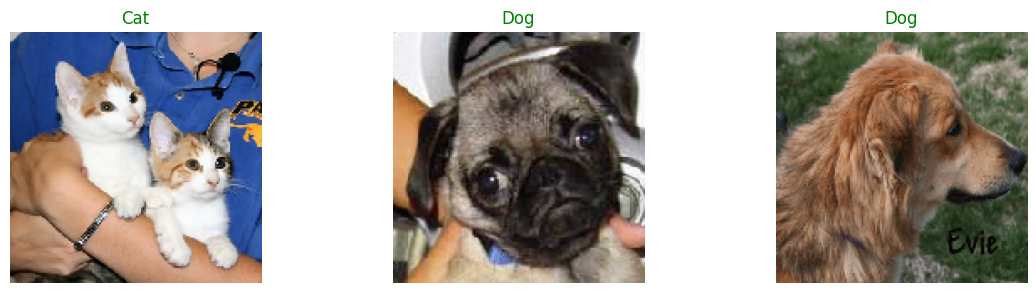

In [45]:
# Plotting Model Predictions on Validation set
plot_prediction(validation_generator, 4)

2/2 [==============================] - 0s 27ms/step


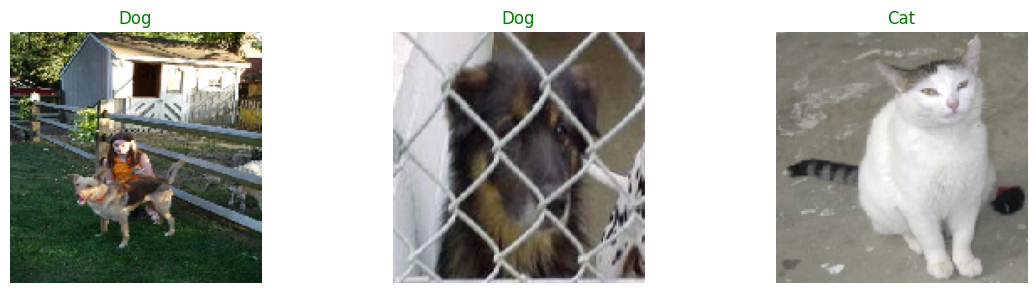

In [46]:
# Plotting Model Predictions on Test set
plot_prediction(test_generator, 4)

In [30]:
# Last Training Results
results = pd.DataFrame(r.history)
results.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.214608,0.914481,0.231637,0.9120
16,0.202702,0.920571,0.222634,0.9176
17,0.185116,0.927016,0.166467,0.9304
18,0.173785,0.933683,0.175840,0.9320
19,0.165300,0.936483,0.228749,0.9096


## Training Process Visualization
Plot the training and validation accuracy/loss over epochs.

In [41]:
fig = px.line(results, y=['accuracy', 'val_accuracy'], 
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Accuracy Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'), 
    yaxis=dict(color='white', title='Accuracy'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()

In [42]:
fig = px.line(results, y=['loss', 'val_loss'], 
              labels={'value': 'Loss', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Loss Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'), 
    yaxis=dict(color='white', title='Loss'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()


## Confusion Matrix
After model evaluation, a confusion matrix for the test set can provide insights into the types of errors your model is making.

2/2 [==============================] - 0s 24ms/step


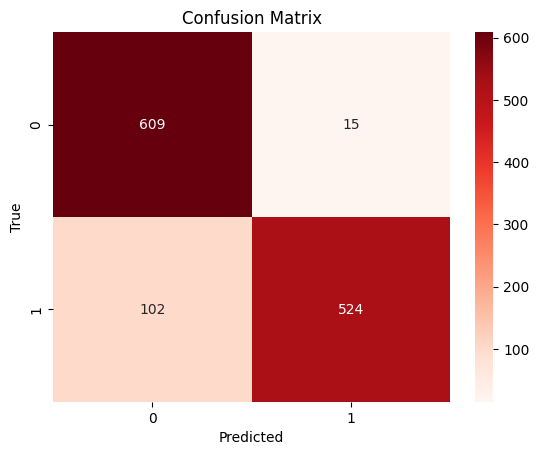

In [47]:
# Initialize arrays to store true labels and predictions
all_labels = []
all_predictions = []

# Loop over all batches in the test set
for _ in range(len(test_generator)):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Append predictions and labels
    all_labels.extend(test_labels)
    all_predictions.extend(predicted_classes)

# Confusion matrix for the entire test set
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve and AUC
For binary classification, plotting the Receiver Operating Characteristic (ROC) curve and calculating the Area Under the Curve (AUC) can be useful to assess the performance across different classification thresholds.

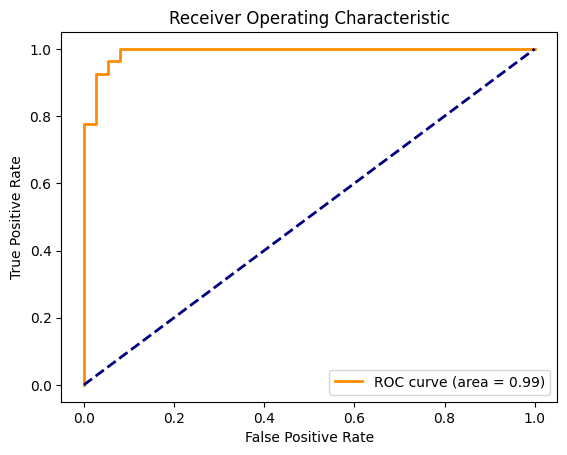

In [38]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Error Analysis
Visualize examples where the model made mistakes. This provides insights into what the model is struggling with.

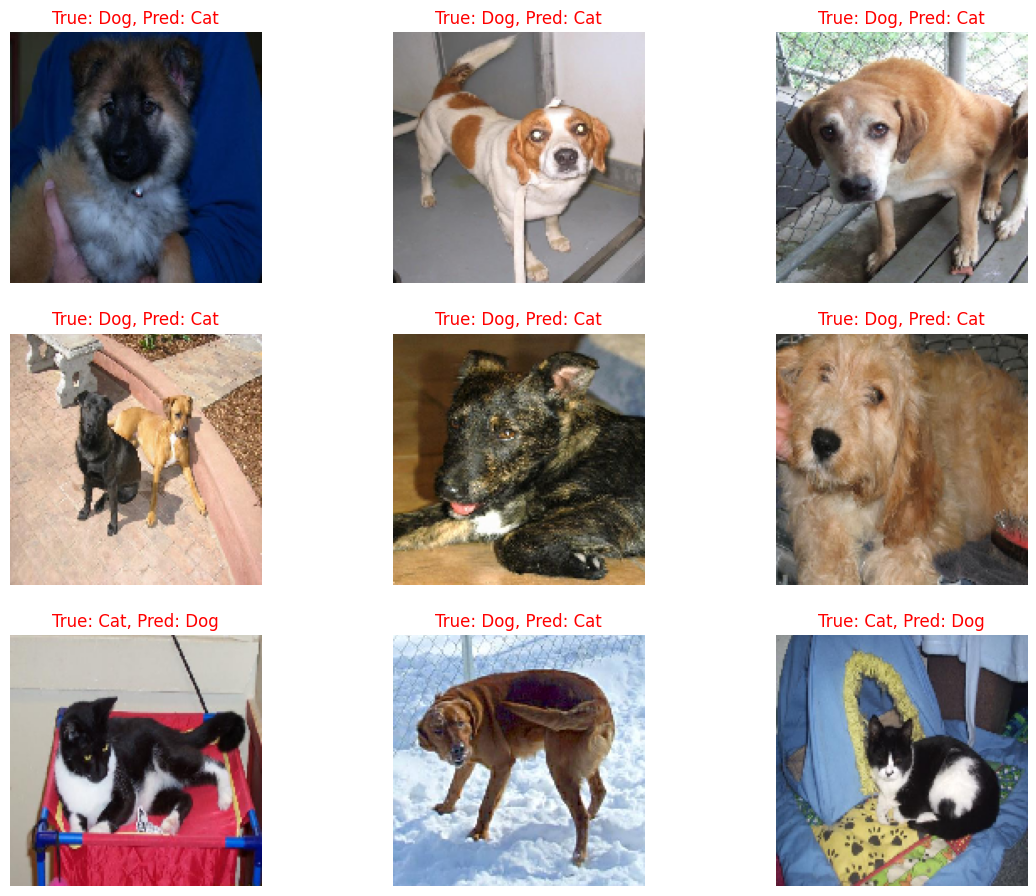

In [40]:
def plot_misclassified_images(generator, predictions, n_images=10):
    images, labels = generator.next()
    misclassified_indices = np.where(predictions != labels)[0]
    misclassified_indices = misclassified_indices[:n_images]
    plt.figure(figsize=(14, 15))
    for i, index in enumerate(misclassified_indices, 1):
        plt.subplot(4, 3, i)
        plt.imshow(images[index])
        plt.title(f"True: {class_names[int(labels[index])]}, Pred: {class_names[int(predictions[index])]}", color='red')
        plt.axis('off')
    plt.show()

plot_misclassified_images(test_generator, predicted_classes, 9)

## Conclusion
The project demonstrated the capabilities of CNNs in image classification, with the model showing good potential in distinguishing between cats and dogs. As with any machine learning project, there is room for improvement. Potential future work could involve experimenting with different model architectures, data augmentation techniques, and hyperparameter tuning to enhance model performance. 

I hope you find it useful. Please let me know if you have any feedback or questions. Thank you!